In [2]:
import json, time, re, nltk, hdbscan, spacy, string
import psycopg2 as pg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sys import getsizeof
from datetime import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from psycopg2.extras import RealDictCursor, Json
from spacy.lang.en.examples import sentences

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(42)

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [34]:
sandy_df = pd.read_csv('data/CrisisLexT6/2012_Sandy_Hurricane/2012_Sandy_Hurricane-ontopic_offtopic.csv')

In [35]:
sandy_df.head()

,tweet id,tweet,label
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,off-topic
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,on-topic
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,off-topic
3,'263422851133079552',@taos you never got that magnificent case of B...,off-topic
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",off-topic


In [36]:
sandy_df['type'] = 'hurricane'

In [37]:
sandy_df.head()

,tweet id,tweet,label,type
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,off-topic,hurricane
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,on-topic,hurricane
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,off-topic,hurricane
3,'263422851133079552',@taos you never got that magnificent case of B...,off-topic,hurricane
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",off-topic,hurricane


In [62]:
sandy_df.columns

Index(['tweet id', ' tweet', 'label', 'type'], dtype='object')

In [98]:
sandy_df.rename(columns={' tweet':'tweet'}, inplace=True)

In [38]:
sandy_df.rename(columns={' label':'label'}, inplace=True)

In [39]:
sandy_df['label'] = sandy_df['label'].map(lambda x: 1 if x=='on-topic' else 0)

In [40]:
sandy_df.head()

,tweet id,tweet,label,type
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,0,hurricane
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,1,hurricane
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,0,hurricane
3,'263422851133079552',@taos you never got that magnificent case of B...,0,hurricane
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",0,hurricane


In [87]:
sandy_df.shape

(10008, 4)

In [41]:
alberta_df = pd.read_csv('data/CrisisLexT6/2013_Alberta_Floods/2013_Alberta_Floods-ontopic_offtopic.csv')

In [53]:
alberta_df.head()

,tweet id,tweet,label,type
0,'348351442404376578',@Jay1972Jay Nope. Mid 80's. It's off Metallica...,off-topic,flood
1,'348167215536803841',Nothing like a :16 second downpour to give us ...,off-topic,flood
2,'348644655786778624',@NelsonTagoona so glad that you missed the flo...,on-topic,flood
3,'350519668815036416',"Party hard , suns down , still warm , lovin li...",off-topic,flood
4,'351446519733432320',@Exclusionzone if you compare yourself to wate...,off-topic,flood


In [47]:
alberta_df['type'] = 'flood'

In [63]:
alberta_df.columns

Index(['tweet id', ' tweet', 'label', 'type'], dtype='object')

In [97]:
alberta_df.rename(columns={' tweet':'tweet'}, inplace=True)

In [51]:
alberta_df.rename(columns={' label':'label'}, inplace=True)

In [54]:
alberta_df['label'] = alberta_df['label'].map(lambda x: 1 if x=='on-topic' else 0)

In [55]:
alberta_df.head()

,tweet id,tweet,label,type
0,'348351442404376578',@Jay1972Jay Nope. Mid 80's. It's off Metallica...,0,flood
1,'348167215536803841',Nothing like a :16 second downpour to give us ...,0,flood
2,'348644655786778624',@NelsonTagoona so glad that you missed the flo...,1,flood
3,'350519668815036416',"Party hard , suns down , still warm , lovin li...",0,flood
4,'351446519733432320',@Exclusionzone if you compare yourself to wate...,0,flood


In [86]:
alberta_df.shape

(10031, 4)

In [58]:
oklahoma_df = pd.read_csv('data/CrisisLexT6/2013_Oklahoma_Tornado/2013_Oklahoma_Tornado-ontopic_offtopic.csv')

In [59]:
oklahoma_df.head()

,tweet id,tweet,label
0,'336908711324962817',@HeatleyJheat44 its barley even raining where ...,on-topic
1,'337052158035890176',Sorry I can't do anything right.,off-topic
2,'339338021751103488',@mrwendell29: @BradSowderWX says we have the ...,on-topic
3,'336339509077762051',#honestyhour I like to wear half split running...,off-topic
4,'337734129972035584',I'm too stressed to have a good summer,off-topic


In [60]:
oklahoma_df['type'] = 'tornado'

In [64]:
oklahoma_df.columns

Index(['tweet id', ' tweet', ' label', 'type'], dtype='object')

In [96]:
oklahoma_df.rename(columns={' tweet':'tweet'}, inplace=True)

In [65]:
oklahoma_df.rename(columns={' label':'label'}, inplace=True)

In [67]:
oklahoma_df['label'] = oklahoma_df['label'].map(lambda x: 1 if x=='on-topic' else 0)

In [68]:
oklahoma_df.head()

,tweet id,tweet,label,type
0,'336908711324962817',@HeatleyJheat44 its barley even raining where ...,1,tornado
1,'337052158035890176',Sorry I can't do anything right.,0,tornado
2,'339338021751103488',@mrwendell29: @BradSowderWX says we have the ...,1,tornado
3,'336339509077762051',#honestyhour I like to wear half split running...,0,tornado
4,'337734129972035584',I'm too stressed to have a good summer,0,tornado


In [85]:
oklahoma_df.shape

(9992, 4)

In [69]:
queensland_df = pd.read_csv('data/CrisisLexT6/2013_Queensland_Floods/2013_Queensland_Floods-ontopic_offtopic.csv')

In [70]:
queensland_df.head()

,tweet id,tweet,label
0,'296728042179534848',"@MarkSDobson I always thought that, big lad ai...",off-topic
1,'296085045645570048',@thamonstar a lot of water moving around and a...,on-topic
2,'296811076400603136',Craig Thompson to be extradited to Victoria on...,off-topic
3,'295357934387486720',"Sunshine state, sort your shit out.",off-topic
4,'296390762210398210',@MarkPhilippi yeah I saw it. He's a wanker. Pa...,off-topic


In [73]:
queensland_df['type'] = 'flood'

In [76]:
queensland_df.columns

Index(['tweet id', ' tweet', ' label', 'type'], dtype='object')

In [100]:
queensland_df.rename(columns={' tweet':'tweet'}, inplace=True)

In [77]:
queensland_df.rename(columns={' label':'label'}, inplace=True)

In [80]:
queensland_df['label'] = queensland_df['label'].map(lambda x: 1 if x=='on-topic' else 0)

In [81]:
queensland_df.head()

,tweet id,tweet,label,type
0,'296728042179534848',"@MarkSDobson I always thought that, big lad ai...",0,flood
1,'296085045645570048',@thamonstar a lot of water moving around and a...,1,flood
2,'296811076400603136',Craig Thompson to be extradited to Victoria on...,0,flood
3,'295357934387486720',"Sunshine state, sort your shit out.",0,flood
4,'296390762210398210',@MarkPhilippi yeah I saw it. He's a wanker. Pa...,0,flood


In [84]:
queensland_df.shape

(10033, 4)

In [101]:
crisislex_df = pd.concat([sandy_df, alberta_df, oklahoma_df, queensland_df])

In [102]:
crisislex_df

,tweet id,tweet,label,type
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,0,hurricane
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,1,hurricane
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,0,hurricane
3,'263422851133079552',@taos you never got that magnificent case of B...,0,hurricane
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",0,hurricane
5,'263101347421888513',Neighborly duties. @Cory_Kennedy arrives to th...,1,hurricane
6,'262763437325684736',And that's it until the spring.,0,hurricane
7,'263298821189156865',I don't know how I'm getting back to Jersey si...,1,hurricane
8,'262813023515865088',@NaeemPeena We were asked to get off the plane...,0,hurricane
9,'262998165282762752',@jaytee_96 you must be crazy! &amp; omg you tw...,0,hurricane


In [103]:
df = crisislex_df

In [104]:
df.head()

,tweet id,tweet,label,type
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,0,hurricane
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,1,hurricane
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,0,hurricane
3,'263422851133079552',@taos you never got that magnificent case of B...,0,hurricane
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",0,hurricane


In [105]:
df.columns

Index(['tweet id', 'tweet', 'label', 'type'], dtype='object')

In [88]:
def processTweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Eliminate hastags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove @ signs
    tweet = re.sub('@', '', tweet)
    return tweet

In [106]:
tweet_list = [i for i in df['tweet']]

In [107]:
tweet_list[:5]

["I've got enough candles to supply a Mexican family",
 'Sandy be soooo mad that she be shattering our doors and shiet #HurricaneSandy',
 '@ibexgirl thankfully Hurricane Waugh played it cool and waited this one out. Ready to go at any moment tho.',
 '@taos you never got that magnificent case of Burgundy I sent you to thank you for your tweets?',
 "I'm at Mad River Bar &amp; Grille (New York, NY) http://t.co/VSiZrzKP"]

Create a column of processed tweets utilizing the created function above:

In [108]:
df['processed'] = [processTweet(i) for i in tweet_list]

In [109]:
df['processed'].str.contains('timberlake').sum()

0

In [110]:
tokenizer = RegexpTokenizer(r'\w+')

In [111]:
df['clean_processed'] = df['processed'].map(lambda x: tokenizer.tokenize(x))

In [112]:
df.head()

,tweet id,tweet,label,type,processed,clean_processed
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,0,hurricane,i've got enough candles to supply a mexican fa...,"[i, ve, got, enough, candles, to, supply, a, m..."
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,"[sandy, be, soooo, mad, that, she, be, shatter..."
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,0,hurricane,ibexgirl thankfully hurricane waugh played it ...,"[ibexgirl, thankfully, hurricane, waugh, playe..."
3,'263422851133079552',@taos you never got that magnificent case of B...,0,hurricane,taos you never got that magnificent case of bu...,"[taos, you, never, got, that, magnificent, cas..."
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",0,hurricane,"i'm at mad river bar &amp; grille (new york, n...","[i, m, at, mad, river, bar, amp, grille, new, ..."


In [113]:
lemmatizer = WordNetLemmatizer()

In [114]:
df['lemm_clean_processed'] = df['clean_processed'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [115]:
df.head()

,tweet id,tweet,label,type,processed,clean_processed,lemm_clean_processed
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,0,hurricane,i've got enough candles to supply a mexican fa...,"[i, ve, got, enough, candles, to, supply, a, m...",i ve got enough candle to supply a mexican family
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,"[sandy, be, soooo, mad, that, she, be, shatter...",sandy be soooo mad that she be shattering our ...
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,0,hurricane,ibexgirl thankfully hurricane waugh played it ...,"[ibexgirl, thankfully, hurricane, waugh, playe...",ibexgirl thankfully hurricane waugh played it ...
3,'263422851133079552',@taos you never got that magnificent case of B...,0,hurricane,taos you never got that magnificent case of bu...,"[taos, you, never, got, that, magnificent, cas...",tao you never got that magnificent case of bur...
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",0,hurricane,"i'm at mad river bar &amp; grille (new york, n...","[i, m, at, mad, river, bar, amp, grille, new, ...",i m at mad river bar amp grille new york ny URL


In [116]:
df.shape

(40064, 7)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40064 entries, 0 to 10032
Data columns (total 7 columns):
tweet id                40064 non-null object
tweet                   40064 non-null object
label                   40064 non-null int64
type                    40064 non-null object
processed               40064 non-null object
clean_processed         40064 non-null object
lemm_clean_processed    40064 non-null object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


In [118]:
lemm_clean_processed_list = [i for i in df['lemm_clean_processed']]

Utilize countvectorizer:

min_df will remember words that are in a document at least once. For example, if min_df = 3, will only remember words that are a part of 3 documents in a corpus. max_df refers to the %-age of documents within a corpus that a word occurs in. For example, if max_df = 0.9, words that occur in more than 90% of my documents will be ignored. By default, max_df is equal to 1.

In [119]:
cv = CountVectorizer(ngram_range = (1,2),
                     stop_words = 'english',
                     min_df = 15,
                     max_df = 1.0)

In [120]:
df_cv = pd.SparseDataFrame(cv.fit_transform(df['lemm_clean_processed']), 
                     columns = cv.get_feature_names())

In [121]:
getsizeof(df_cv)

2730160

In [122]:
df_cv.fillna(0, inplace=True)

In [123]:
df_cv.columns

Index(['00', '00 humidity', '000', '000 evacuated', '000 help', '000 home',
       '000 people', '01', '04', '10',
       ...
       'yycflood yyc', 'yycflood yychelps', 'yycfloods', 'yychelps',
       'yychelps url', 'yychelps yycflood', 'zero', 'zombie', 'zone', 'zoo'],
      dtype='object', length=4104)

Perform SVD to reduce dimensionality to about ~1000 (Currently ~1800)...Have to run an instance with about ~8GB of RAM (~0.08cents to perform one calculation); shut off the instance and restart this instance.. 

tfidf dataframe

custom_stop = ['url',
               'rt',
               'mitchellvii',
               'wa',
               'ha',
               'just',
               'good',
               'free',
               'purchase',
               'shipping',
               'don',
               'buy',
               'sale',
               'snkrconnecthq',
               
              ]

stop_words = ENGLISH_STOP_WORDS.union(custom_stop)

In [124]:
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        stop_words = 'english', 
                        min_df = 25, 
                        max_df = 1.0)

In [125]:
df_tfidf = pd.SparseDataFrame(tfidf.fit_transform(df['lemm_clean_processed']),
                        columns = tfidf.get_feature_names())

In [126]:
df_tfidf.shape

(40064, 2599)

In [127]:
df_tfidf.fillna(0, inplace = True)

In [128]:
df_tfidf.head()

,00,00 humidity,000,000 help,000 home,000 people,10,10 donation,10 online,100,...,yycflood abflood,yycflood relief,yycflood url,yycflood yyc,yycflood yychelps,yycfloods,yychelps,yychelps yycflood,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD

In [129]:
SVD = TruncatedSVD(n_components=1000) 
# doesn't center out data...versus PCA which it does...
# ##If we didn't fit before train_test_split (WHY DO WE NEED TO FIT TRANSFORM BEFORE TRAIN TEST SPLIT...)
svd_matrix = SVD.fit_transform(df_tfidf)
svd_matrix.shape

(40064, 1000)

In [130]:
component_names = pd.Series(["component_"+str(i+1) for i in range(1000)])

In [131]:
SVD.components_.shape

(1000, 2599)

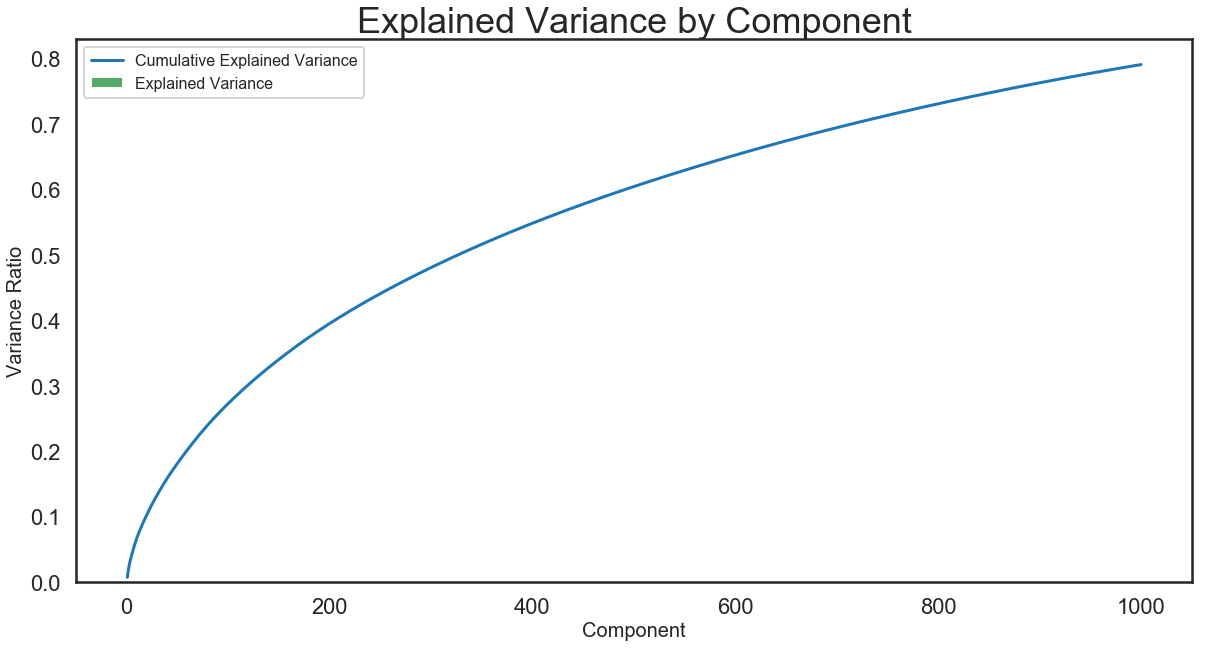

In [132]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(1000))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='Explained Variance')
plt.plot(np.array(range(1000))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='Cumulative Explained Variance')
plt.legend(fontsize=16)
plt.xlabel('Component', fontsize=20)
plt.ylabel('Variance Ratio', fontsize=20)
plt.title('Explained Variance by Component', fontsize=36);

In [133]:
np.cumsum(SVD.explained_variance_)

array([0.00736797, 0.0185594 , 0.02671206, 0.03360238, 0.03895378,
       0.0447664 , 0.05032764, 0.05542397, 0.06023892, 0.06468267,
       0.06889785, 0.07296009, 0.07675043, 0.08048101, 0.08411482,
       0.08769583, 0.09102194, 0.09433565, 0.09754953, 0.10073297,
       0.10388322, 0.10699229, 0.11003123, 0.11303719, 0.11595322,
       0.11880555, 0.12165442, 0.12443329, 0.127196  , 0.12993487,
       0.13262559, 0.13525268, 0.13785029, 0.14042487, 0.14297965,
       0.14552132, 0.14800376, 0.15047394, 0.15290212, 0.15530434,
       0.1576518 , 0.15995448, 0.16224517, 0.16449978, 0.16673738,
       0.1689381 , 0.17112452, 0.17329877, 0.17546178, 0.17761511,
       0.17974674, 0.18185215, 0.18395248, 0.18603782, 0.1881128 ,
       0.19018297, 0.19223789, 0.19425844, 0.19626368, 0.19825851,
       0.20023751, 0.20220585, 0.20416327, 0.20609551, 0.2080205 ,
       0.20993703, 0.21184408, 0.21374221, 0.21562994, 0.21750193,
       0.21936025, 0.22121263, 0.22303576, 0.22484617, 0.22664

In [134]:
component_names = ["component_"+str(i+1) for i in range(1000)]
svd_df = pd.SparseDataFrame(svd_matrix,columns=component_names)

In [135]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_991,component_992,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000
0,0.029349,-0.001943,0.026707,0.004338,0.047865,-0.006090,-0.017847,-0.002431,0.003907,-0.002314,...,0.005047,-0.011628,0.011736,-0.000947,-0.006408,0.012208,-0.002711,-0.009077,-0.008953,0.003510
1,0.102503,0.102571,-0.045761,0.000168,-0.018075,0.005319,0.001784,-0.027639,-0.010600,-0.012168,...,0.002300,-0.006826,-0.009075,-0.000620,0.001721,0.000213,-0.004842,0.001919,0.002329,0.009788
2,0.094847,0.087241,-0.023881,0.002041,0.014111,-0.004119,-0.019959,0.002998,0.002544,0.003979,...,-0.020152,0.001194,-0.013519,0.013593,0.000895,-0.003933,-0.005465,-0.000403,-0.013939,0.017307
3,0.028286,0.004010,0.019068,0.002974,0.060708,-0.007110,-0.008888,-0.002042,0.000425,-0.013760,...,-0.037461,0.018084,0.010290,-0.019064,-0.024100,0.010879,0.018793,0.029034,-0.001680,0.013092
4,0.094667,-0.039631,-0.012979,-0.019618,0.018219,-0.018374,0.143671,-0.159400,0.106714,-0.013882,...,-0.005678,-0.001708,0.008312,-0.000649,-0.002727,0.017553,-0.014759,0.005650,-0.006371,-0.003488


In [136]:
loadings = pd.SparseDataFrame(SVD.components_,
                              index=component_names,
                              columns=df_tfidf.columns).T

In [137]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings['abs_component_3'] = np.abs(loadings.component_3)
loadings['abs_component_4'] = np.abs(loadings.component_4)

In [138]:
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_995,component_996,component_997,component_998,component_999,component_1000,abs_component_1,abs_component_2,abs_component_3,abs_component_4
00,0.009317,-0.007526,0.003277,-0.000504,0.002514,0.007314,0.025430,-0.016805,-0.008583,-0.000752,...,0.011060,0.009096,-0.003910,-0.012887,0.008537,-0.002951,0.009317,0.007526,0.003277,0.000504
00 humidity,0.000304,-0.000108,0.000226,-0.000032,0.000707,-0.000040,0.000168,-0.000093,-0.000053,-0.000042,...,-0.004247,0.003043,0.002808,-0.002617,-0.004975,0.000998,0.000304,0.000108,0.000226,0.000032
000,0.011256,-0.008023,0.007192,-0.002112,0.003386,0.002498,0.013885,0.014753,-0.000940,0.001368,...,0.008875,0.011745,0.016361,-0.027737,0.008476,-0.010770,0.011256,0.008023,0.007192,0.002112
000 help,0.001703,0.001344,0.000034,-0.000084,-0.001119,0.000084,0.000291,0.001512,-0.000018,0.000032,...,-0.005061,0.004954,-0.000846,0.001947,-0.000671,-0.000007,0.001703,0.001344,0.000034,0.000084
000 home,0.001390,-0.001963,-0.000078,-0.000582,0.000504,0.000447,0.001913,0.000877,0.000296,-0.000192,...,0.005499,0.003963,0.003570,0.006366,-0.004167,-0.000312,0.001390,0.001963,0.000078,0.000582


In [139]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
hurricane,0.424435
url,0.393110
rt,0.373403
sandy,0.341029
hurricane sandy,0.303992
flood,0.213590
oklahoma,0.135786
queensland,0.113257
tornado,0.110988
australia,0.099318


In [140]:
loadings.sort_values('abs_component_2',ascending=False).head(20)[['component_2']]

,component_2
hurricane,0.438366
flood,-0.387289
sandy,0.360449
hurricane sandy,0.330181
url,-0.307942
queensland,-0.217392
australia,-0.198948
queensland flood,-0.127993
water,-0.104840
rise,-0.099506


In [141]:
loadings.sort_values('abs_component_3',ascending=False).head(20)[['component_3']]

,component_3
oklahoma,0.450609
tornado,0.323445
flood,-0.281741
rt,0.270795
australia,-0.189391
queensland,-0.171993
sandy,-0.171925
hurricane,-0.156731
hurricane sandy,-0.156453
prayer,0.150478


In [142]:
loadings.sort_values('abs_component_4',ascending=False).head(20)[['component_4']]

,component_4
baby,0.209988
storm,0.203156
flood australia,0.199333
powerful storm,0.195875
stuffed,0.195643
amazing,0.195594
australia powerful,0.195439
storm led,0.195439
led,0.195409
powerful,0.195367


In [143]:
cos_sim_mat = cosine_similarity(svd_df, svd_df)
cos_sim_mat.shape

(40064, 40064)

In [144]:
np.argsort(cos_sim_mat[1])[:-11:-1]

array([    1, 22744,  3429, 33258,  4207, 11705,  4407,  1953, 25021,
       31505])

In [145]:
np.sort(cos_sim_mat[1])[:-11:-1]

array([1.        , 0.56338142, 0.56338142, 0.55302336, 0.55302336,
       0.54650116, 0.52810135, 0.50916872, 0.48533281, 0.48444434])

### HDBSCAN

plt.figure(figsize=(20,10));
# plt.scatter(df_tfidf.T[0], df_tfidf.T[1])

In [146]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 50, gen_min_span_tree = True)
cluster.fit(svd_df)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=50, min_samples=None, p=None,
    prediction_data=False)

In [147]:
cluster.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [148]:
plt.figure(figsize=(20,10))
cluster.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                    edge_alpha=0.6,
                                    node_size=80,
                                    edge_linewidth=2)

AttributeError: No minimum spanning tree was generated.This may be due to optimized algorithm variations that skip explicit generation of the spanning tree.

<Figure size 1440x720 with 0 Axes>

## We can also visually represent the clustering hierarchy

plt.figure(figsize=(20,10))
cluster.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

## If we condense this plot, we can get a better idea of our final clusters

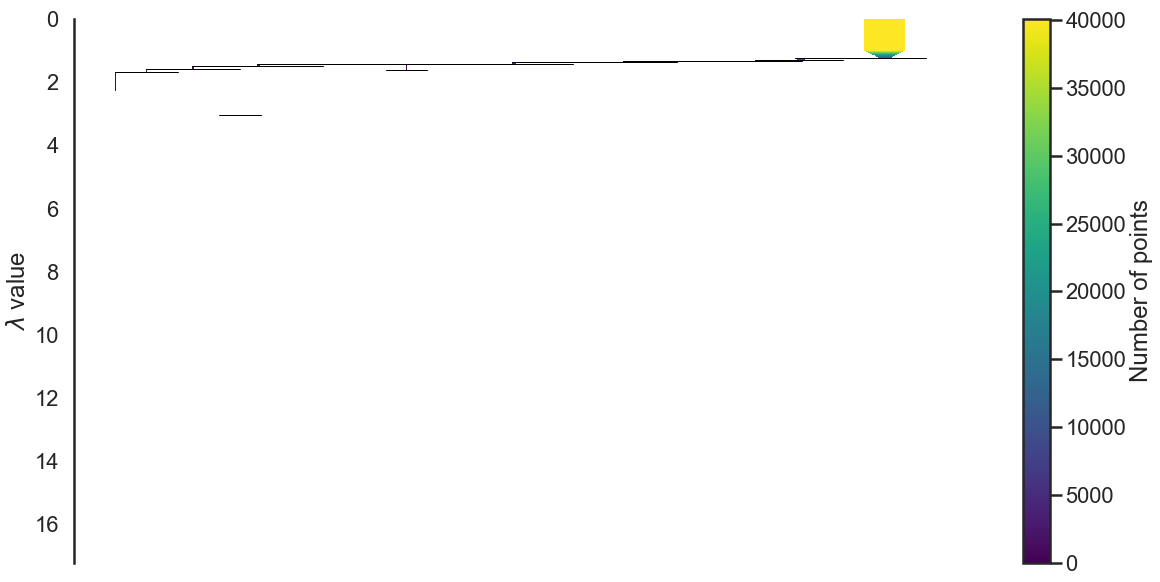

In [149]:
plt.figure(figsize=(20,10))
cluster.condensed_tree_.plot()

## And then we can actually visually represent which clusters are selected

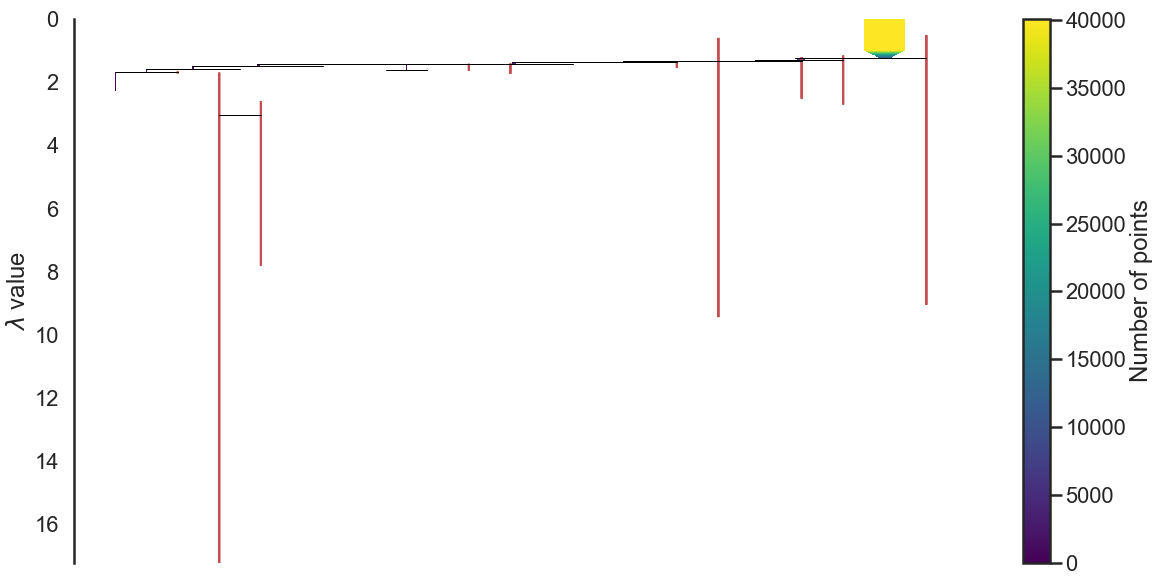

In [150]:
plt.figure(figsize=(20,10))
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())